<a href="https://colab.research.google.com/github/cezargfilho/amazon-activefire-dnn/blob/main/TF_com_Keras_2_CNN_BatchNORM_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install gdown
!gdown --id 1lzZ79vkk1VVvVNR0NfWVDOpmeovHnsXN
!unzip dataset_brazil_amazon_v3.zip

# https://drive.google.com/file/d/1WCpShrH3FOoy14AAYATHyZYZum8hVQrd/view?usp=sharing V2
# https://drive.google.com/file/d/1lzZ79vkk1VVvVNR0NfWVDOpmeovHnsXN/view?usp=sharing V3

# Image Augmentation

In [ ]:
!pip  install  Augmentor

In [ ]:
import Augmentor

p = Augmentor.Pipeline('./dataset_brazil_amazon_v2/train/1/')
p.rotate(probability=1, max_left_rotation=10, max_right_rotation=10)
# p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.flip_top_bottom(0.5)

p.sample(18219)

p.process()

Quantidade de imagens em cada diretório

In [ ]:
import os

print('total training fires images:', len(os.listdir('./dataset_brazil_amazon_v3/train/1')))
print('total training non fires images:', len(os.listdir('./dataset_brazil_amazon_v3/train/0')))
print('--------------------------------------')
print('total test fires images:', len(os.listdir('./dataset_brazil_amazon_v3/test/1')))
print('total test non fires images:', len(os.listdir('./dataset_brazil_amazon_v3/test/0')))

In [ ]:
!mv  /content/dataset_brazil_amazon_v2/train/1/output /content/
!rm -fr /content/dataset_brazil_amazon_v2/train/1
!mv /content/output/ /content/1
!mv -f /content/1  /content/dataset_brazil_amazon_v2/train/

Eliminando diretórios /.ipynb_checkpoints

In [5]:
train_dir = os.listdir("/content/dataset_brazil_amazon_v3/train") #First find where the ".ipynb_checkpoints" is located.
test_dir = os.listdir("/content/dataset_brazil_amazon_v3/test")
print(train_dir, test_dir)

shutil.rmtree("/content/dataset_brazil_amazon_v3/train/.ipynb_checkpoints")
shutil.rmtree("/content/dataset_brazil_amazon_v3/test/.ipynb_checkpoints")


['.ipynb_checkpoints', '1', '0'] ['.ipynb_checkpoints', '1', '0']


# Rede

Imports

In [2]:
import tensorflow as tf
import keras_preprocessing
import numpy as np
import random
import time
import cv2
import os, glob
import sys
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [3]:
TRAIN_FOLDER = '/content/dataset_brazil_amazon_v3/train'
TEST_FOLDER = '/content/dataset_brazil_amazon_v3/test'  
SPLIT_RATE = 0.8       
BATCH_SIZE = 100

IMAGE_HEIGHT = 128  # height of the image
IMAGE_WIDTH = 128   # width of the image
NUM_CHANNELS = 3   # number of channels of the image

Carregando imagens

In [6]:
#Tensor para treino

train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_FOLDER,
  seed=123,
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE
  )
print(train_ds.class_names)

#train_ds = train_ds/float(255)

Found 173528 files belonging to 2 classes.
['0', '1']


Tensor para validação

In [7]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_FOLDER,
  seed=123,
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE
  )
#test_ds = test_ds/float(255)

Found 38827 files belonging to 2 classes.


# Converter tf.data.Dataset para Numpy arrays

In [8]:
import tensorflow_datasets as tfds

In [9]:
def to_numpy_array(data_dataset):
  x = None
  y = None
  for image_batch, labels_batch in tfds.as_numpy(train_ds):
    x = image_batch
    y = labels_batch
  return x, y

In [10]:
x_train, y_train = to_numpy_array(train_ds)
x_test, y_test = to_numpy_array(test_ds)

In [ ]:
print(x_train, y_train)
print(x_test, y_test)

In [12]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Plotando Imagens

['0', '1']


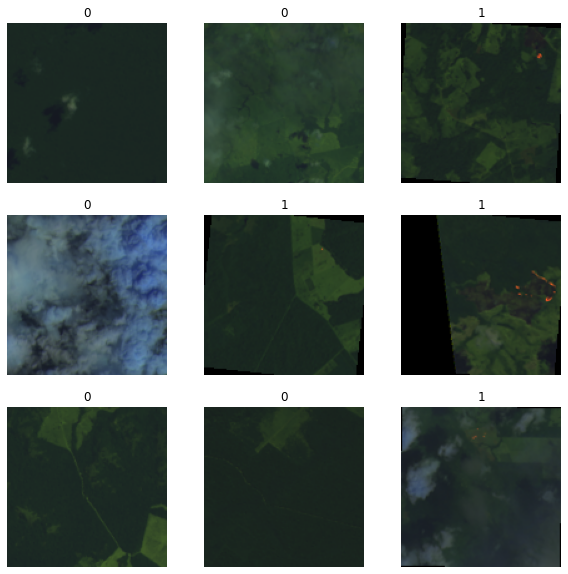

In [14]:
class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Definição da Rede Neural

Configuração de desempenho

*   **Dataset.cache** mantém as imagens na memória depois de serem carregadas fora do disco durante a primeira época. Isso garantirá que o conjunto de dados não se torne um gargalo durante o treinamento do seu modelo. Se o seu conjunto de dados for muito grande para caber na memória, você também pode usar este método para criar um cache em disco de alto desempenho.
*   **Dataset.prefetch** sobrepõe dados de pré-processamento e execução do modelo durante o treinamento.



In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Construindo o modelo

In [16]:
# kernel_size= tamanho do kernel / strides= passo do kernel

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 128X128 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), padding='valid',activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [18]:
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer='adam', 
    metrics=['accuracy']
    )


history = model.fit(
            x_train, y_train, 
            epochs=30,
            shuffle=True,
            #steps_per_epoch=100, 
            validation_data = (x_test, y_test)
            )

model.save("amazon_fire.keras")

Epoch 1/30
1/1 [==============================] - 31s 31s/step - loss: 0.6933 - accuracy: 0.4286 - val_loss: 0.7010 - val_accuracy: 0.4286
Epoch 2/30
1/1 [==============================] - 0s 93ms/step - loss: 0.6872 - accuracy: 0.6071 - val_loss: 0.7025 - val_accuracy: 0.4286
Epoch 3/30
1/1 [==============================] - 0s 86ms/step - loss: 0.6742 - accuracy: 0.6071 - val_loss: 0.6962 - val_accuracy: 0.6429
Epoch 4/30
1/1 [==============================] - 0s 84ms/step - loss: 0.6623 - accuracy: 0.7143 - val_loss: 0.6911 - val_accuracy: 0.6786
Epoch 5/30
1/1 [==============================] - 0s 84ms/step - loss: 0.6439 - accuracy: 0.7143 - val_loss: 0.7856 - val_accuracy: 0.4286
Epoch 6/30
1/1 [==============================] - 0s 84ms/step - loss: 0.6652 - accuracy: 0.6071 - val_loss: 0.6920 - val_accuracy: 0.5357
Epoch 7/30
1/1 [==============================] - 0s 86ms/step - loss: 0.7188 - accuracy: 0.5000 - val_loss: 0.7244 - val_accuracy: 0.4643
Epoch 8/30
1/1 [===========

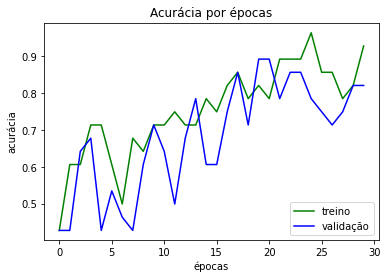

<Figure size 432x288 with 0 Axes>

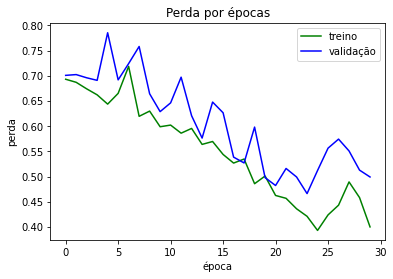

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, color='green', label='treino')
plt.plot(epochs, val_acc, 'b', label='validação')
plt.title('Acurácia por épocas')
plt.legend(loc='lower right') # 'upper left', 'upper right', 'lower left', 'lower right')
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.figure()
plt.show()

plt.plot(epochs, loss, color='green', label='treino')
plt.plot(epochs, val_loss, 'b', label='validação')
plt.title('Perda por épocas')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('perda')
plt.figure()
plt.show()

# Predição

In [20]:
test_pred_y = model.predict(x_test)

In [21]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print(test_acc)

1/1 - 0s - loss: 0.4992 - accuracy: 0.8214
0.8214285969734192
